# CS375 - Assignment 2 - VAE

This was quite a journey. We aren't that confident in any statement, given that the model isn't a fantastic autoencoder, but here they are anyway!

## ImageNet training and testing

In [28]:
%matplotlib inline 
import os
import numpy as np
import tensorflow as tf
import pymongo as pm
import gridfs
import cPickle
import scipy.signal as signal
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, trange

In [7]:
from dldata.metrics.utils import compute_metric_base

### Getting data from the database
Let's connect to the database and pull the data training and test data that is stored while training our network.
In order to find the right experiment id, it is useful to display which experiments are stored in the database first.

In [8]:
# connect to database
dbname = 'assignment2'
collname = 'VAE'
exp_id = '1st_experiment'
port = 24444

conn = pm.MongoClient(port = port)
coll = conn[dbname][collname + '.files']

# print out saved experiments in collection coll
print(coll.distinct('exp_id'))

[u'1st_experiment']


In [9]:
q_train = {'exp_id' : exp_id, 'validates' : {'$exists' : True}}
out = coll.find(q_train)
list(out)[0]['validation_results'].keys()

[u'V6', u'VAll']

In [85]:
#coll.remove({'exp_id': exp_id})

This shows us all stored experiments. In case you want to delete a particular experiment because you are running out of disk space, you can uncomment and use the following line. You could also just drop the entire collection or even the entire database if you want to get of all of them, but I recommend removing them one by one.

### Plotting the training curve
Now we are interested to see the training curve for exp_id='experiment_1' for example. So the first thing we have to do is to pull the training loss from the database and then we can plot it. I implemented a function that will pull and return the training loss per iteration for you.

Your first task is to take the training loss and plot 1.) the training loss and 2.) a smoothed version of the training loss which you can effectively get by convolving the loss with a vector of ones kernel. You might find the function 'scipy.signal.convolve' useful to solve this task. Experiment with various kernel lengths and describe what you see.

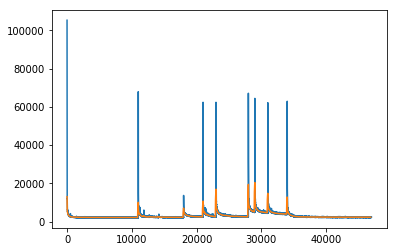

In [10]:
from scipy.signal import convolve

def smooth_signal(lst, smooth=5):
    return convolve(lst, np.ones((smooth))/smooth, 'valid')

def get_losses(coll, exp_id):
    """
    Gets all loss entries from the database and concatenates them into a vector
    """
    q_train = {'exp_id' : exp_id, 'train_results' : {'$exists' : True}}
    return np.array([_r['loss'] 
                     for r in coll.find(q_train, projection = ['train_results']) 
                     for _r in r['train_results']])

loss = get_losses(coll, exp_id)
# loss_mini = get_losses(coll_mini, exp_id)

# Plot the training loss
plt.plot(loss)
plt.plot(smooth_signal(loss,100))



Multiple losses from different implementations. The best autoencoder actually had a single convolutional layer, but we moved to a deep VAE with the hopes that doing so would lead to better correspondence with neural data (which it did...somewhat). Couldn't really get it to be a great autoencoder though. We played with the number of layers, the learning rate, the number of filters, and the size of the latent space, but to no avail! Perhaps changing the activation layer from tanh to relu would help, or regularizing in some way.

### Plotting the validation results
After our train_imagenet function has evaluated the Image Net validation set for the time we can have a look at the validation results of for example exp_id='experiment_1'. Again, you need to pull the validation data from the database first. The validation data consists of the top1 and top5 accuracy that you have implemented previously. 

We have provided a function that pulls the necessary data from the database. Your task is to plot the validation curve of the top1 and top5 accuracy. Label the graphs respectively and describe what you see.

In [11]:
def get_validation_images(exp_id):
    """
    Gets the validation images from the database
    """
    q_val = {'exp_id' : exp_id, 'validation_results' : {'$exists' : True}, 'validates' : {'$exists' : False}}
    val_steps = coll.find(q_val, projection = ['validation_results'])
    last_val_i = val_steps.count()-1
    pred = np.array(val_steps[last_val_i]['validation_results']['valid0']['pred'])
    gt = np.array(val_steps[last_val_i]['validation_results']['valid0']['gt'])
    return {'gt': gt, 'pred': pred}

def plot_validation_images(exp_id, n_images = 24):
    '''
    Plots n_images images in a grid. The ground truth image is on the left 
    and the prediction is on the right.
    '''
    imgs = get_validation_images(exp_id)
    fig = plt.figure(figsize=(16, 16))
    img_shape = imgs['gt'].shape[2:]
    for i in range(n_images):
        pred = imgs['pred'][i]
        plt.subplot(n_images/4,n_images/3,1 + i*2)
        plt.imshow(pred, cmap='gray')
        ax = plt.gca()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        
        gt = imgs['gt'][i]
        plt.subplot(n_images/4,n_images/3,2 + i*2)
        plt.imshow(gt, cmap='gray')
        ax = plt.gca()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

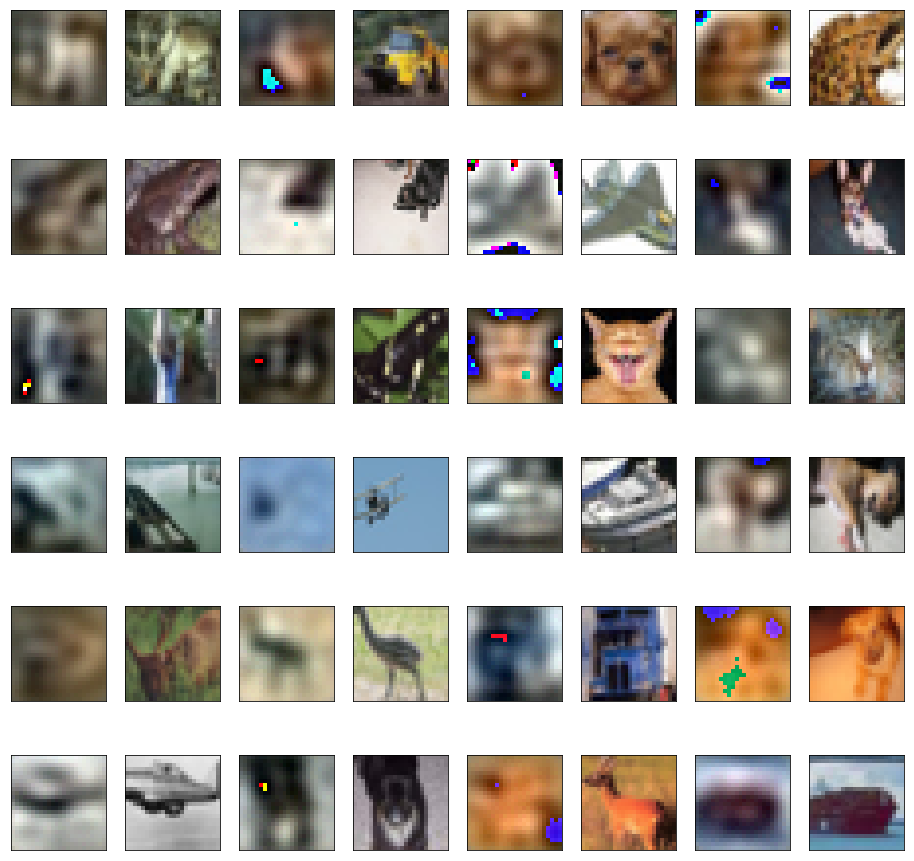

In [12]:
#out = get_validation_images('1st_experiment')
plot_validation_images(exp_id, 24)

All that said, things *are* being reconstructed. Not sure exactly what causes the extreme pixel values on some of the images, but you can definitely tell which image it is going for!

## Neural analysis


In [29]:
def get_neural_validation_data(exp_id):
    q_val = {'exp_id' : exp_id, 'validation_results' : {'$exists' : True}, 'validates': {'$exists' : True}}
    val_steps = coll.find(q_val, projection = ['validation_results', 'validates', 'exp_id'])
    results = [val_steps[i] for i in range(val_steps.count())]
    for res in results:
        res['step'] = coll.find({'_id': res['validates']})[0]['step']
    return results

validation_data = get_neural_validation_data(exp_id=exp_id)
print('data keys:')
print(validation_data[0].keys())

data keys:
[u'exp_id', 'step', u'_id', u'validates', u'validation_results']


In [31]:
"""
You will need to EDIT this part.
Please subselect 'validation_data' with 'idx' to pick the data entry for your desired iteration step.
1.) Assign 
    data = 'validation_data[idx]['validation_results']['valid0']'
and
    step = validation_data[idx]['step']
2.) Choose the target_layers you want to evaluate on.
"""
target_layers = ['conv1', 'conv2', 'conv3', 'z']
idx = -1 ### YOUR idx HERE
data_all = validation_data[idx]['validation_results']['VAll']
data_6 = validation_data[idx]['validation_results']['V6']
step = validation_data[idx]['step']

### Analyzing the RDM results


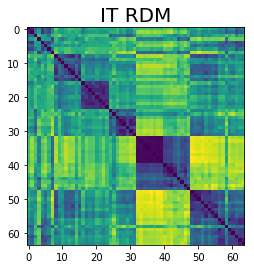

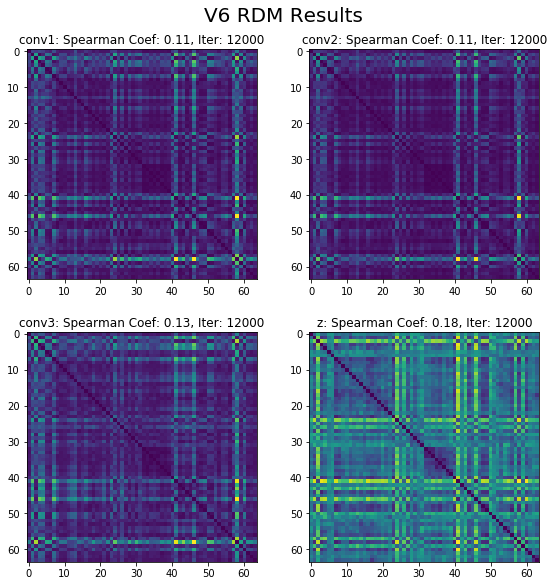

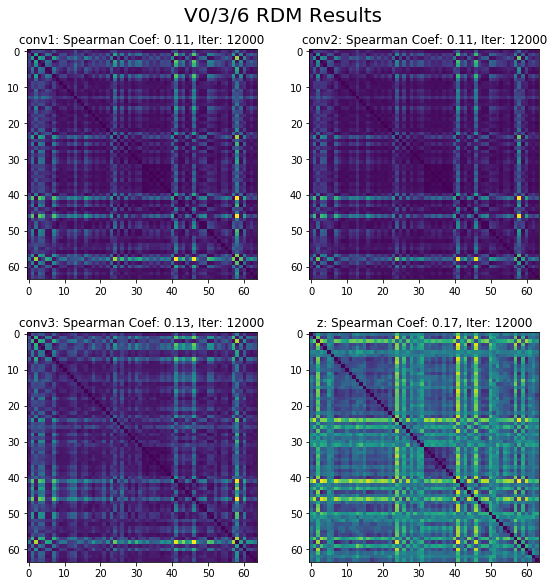

In [19]:
from math import ceil

def plot_rdms(data, target_layers, step):
    """
    Displays the RDMs of all target layers.
    
    You will need to EDIT this part. Please implement a function that visualizes 
    the rdms of all target_layers and displays the layer name as well as the 
    spearman_corrcoef in the plot title.
    """
    ncols = 2
    nrows = ceil(len(target_layers)/float(ncols))
    plot_size = 4
    f = plt.figure(figsize=(plot_size*ncols, plot_size*nrows))
    for i, layer in enumerate(target_layers):
        rdm = data['rdm_%s' % layer]
        spearman_corrcoef = data['spearman_corrcoef_%s' % layer]
        ### YOUR CODE HERE
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(rdm)
        plt.title('%s: Spearman Coef: %.2f, Iter: %s' % (layer, spearman_corrcoef, step))
        ### END OF YOUR CODE
    plt.tight_layout()


plt.title('IT RDM', fontsize=20)
plt.imshow(data_all['rdm_it'])

plot_rdms(data_6, target_layers, step)
plt.suptitle('V6 RDM Results', fontsize=20, y=1.02)

plot_rdms(data_all, target_layers, step)
plt.suptitle('V0/3/6 RDM Results', fontsize=20, y=1.02)

The z layer looks substantially better than the convolutional layers, but still awful. It doesn't seem to be segmenting categories very well, which makes some sense. It has no access to category information! The only information that *would* lead to category representation is pixel-level similarity. While that causes a very small bit of clustering, it's nothing like the results we get from a supervisory signal. I imagine a refinrocement signal could also work well, given that different visual stimuli require different actions (for example)

### Analyzing the categorization results


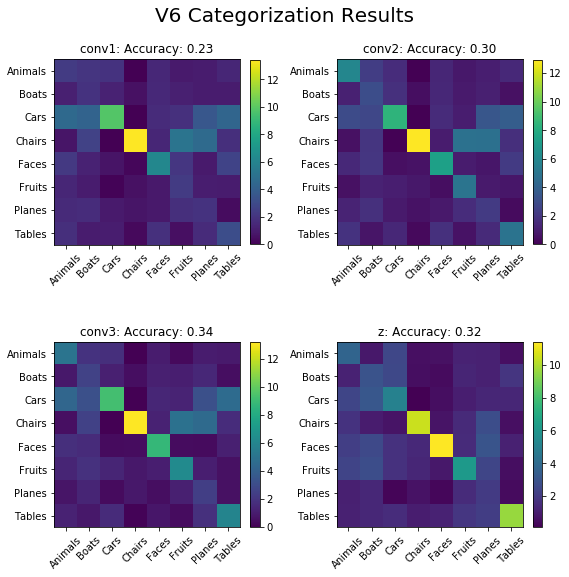

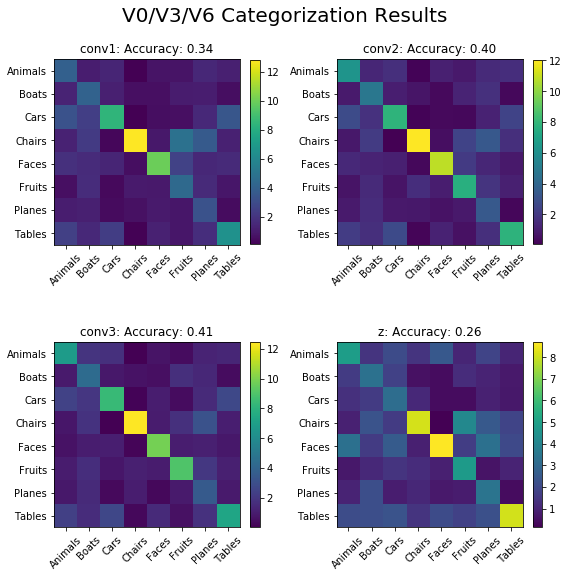

In [20]:
def plot_categorization_results(data, target_layers, step):
    """
    Plots the confusion matrix and the average classification accuracy for each layer.
    
    You will need to EDIT this section.
    """
    ncols = 2
    nrows = ceil(len(target_layers)/ncols)
    plot_size = 4
    f = plt.figure(figsize=(plot_size*ncols, plot_size*nrows))

    for i, layer in enumerate(target_layers):
        k = 'categorization_%s' % layer
        categorization_results = data[k]['result_summary']
        ### YOUR CODE HERE
        confusion = np.vstack([np.mean(performance, 1) for performance in categorization_results['cms']])
        acc = (np.mean(categorization_results['accbal'])-.5)*2 # why this?
        # plot
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(confusion)
        plt.xticks(range(8), categorization_results['labelset'], rotation=45)
        plt.yticks(range(8), categorization_results['labelset'])
        plt.colorbar(fraction=.045)
        plt.title('%s: Accuracy: %.2f' % (layer, acc))
        ### END OF YOUR CODE
    plt.tight_layout()
        
plot_categorization_results(data_6, target_layers, step)
plt.suptitle('V6 Categorization Results', fontsize=20, y=1.02)
plot_categorization_results(data_all, target_layers, step)
plt.suptitle('V0/V3/V6 Categorization Results', fontsize=20, y=1.02)


Summarizing the results: it isn't very good! It seems best at categorizing the images that popped out of the RSA, implying that, again, the space the autoencoder projects the images into maintains some kind of physical pixel level information that is not very similar to the category labels. That said, we can see the diagonal pop out, showing that the representations aren't totally useless for categorization.

### Analyzing the within categorization reuslts

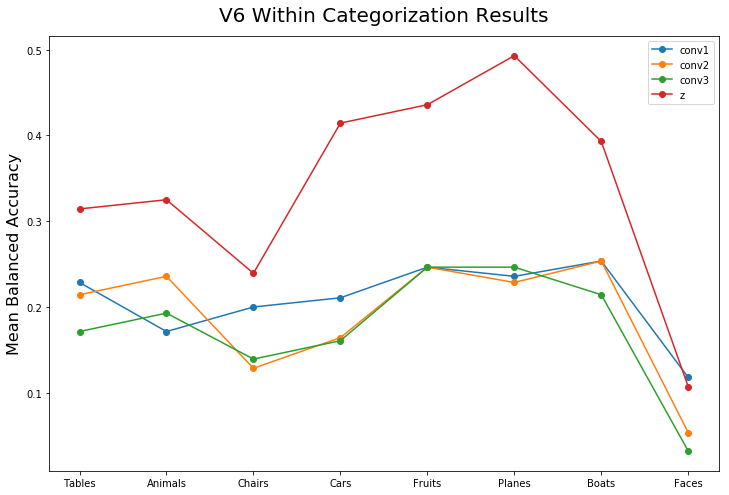

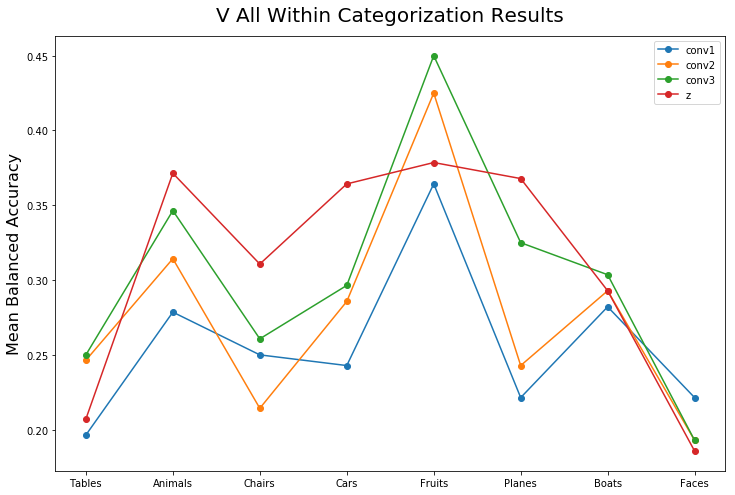

In [23]:
def plot_within_categorization_results(data, target_layers):
    plt.figure(figsize=(12,8))
    for i, layer in enumerate(target_layers):
        layer_results = data['within_categorization_%s' % layer]
        performance = [(k, (np.mean(v['result_summary']['accbal'])-.5)*2) for k,v in layer_results.items()]
        plt.plot([i[1] for i in performance], '-o', label=layer)
    plt.xticks(range(len(performance)), [i[0] for i in performance])
    plt.ylabel('Mean Balanced Accuracy', fontsize=16)
    plt.legend()
    
plot_within_categorization_results(data_6, target_layers)
plt.title('V6 Within Categorization Results', fontsize=20, y=1.02)

plot_within_categorization_results(data_all, target_layers)
plt.title('V All Within Categorization Results', fontsize=20, y=1.02)


The hidden layer performs substantially better across categories. It actually does almost as well on within category categorization as between

### Analyzing the regression results

We will now display the results of the regression test. 

Please print (1 - data['it\_regression_"insert_target_layer_here"']['noise_corrected_multi_rsquared_loss']) for each layer and step and label the print out with the layer name and step. Describe what you observe.

In [25]:
def plot_regression_results(data, target_layers, step):
    """
    Prints out the noise corrected multi rsquared loss for each layer.
    
    You will need to EDIT this function.
    """
    for layer in target_layers:
        k = 'it_regression_%s' % layer
        regression_results = data[k]
        ### YOUR CODE HERE
        performance = 1-regression_results['noise_corrected_multi_rsquared_loss']
        print('layer: %s, step: %s, performance: %.2f' % (layer, step, performance))
        ### END OF YOUR CODE
        
print('********** V 6 *********************')
plot_regression_results(data_6, target_layers, step)
print('\n********** V All ******************')
plot_regression_results(data_all, target_layers, step)

********** V 6 *********************
layer: conv1, step: 12000, performance: -0.00
layer: conv2, step: 12000, performance: 0.03
layer: conv3, step: 12000, performance: 0.04
layer: z, step: 12000, performance: 0.01

********** V All ******************
layer: conv1, step: 12000, performance: 0.03
layer: conv2, step: 12000, performance: 0.08
layer: conv3, step: 12000, performance: 0.08
layer: z, step: 12000, performance: 0.02


Here we see the substantial similarity between IT cortex and the autoencoder, with a large, brilliant...just kidding. It can't predict anything. Oh well!

### Visualizing the conv1 kernels
Lastly, we will plot the conv1 filter kernels. 

Your task is to visualize the 'conv1_kernel' in a 12 x 8 grid. Therefore, you just have to plot each kernel as an image in a subplot. The kernels are stored in data['conv1_kernel']. Print out the iteration step and plot the kernels and describe what you see.

Iteration step: 12000


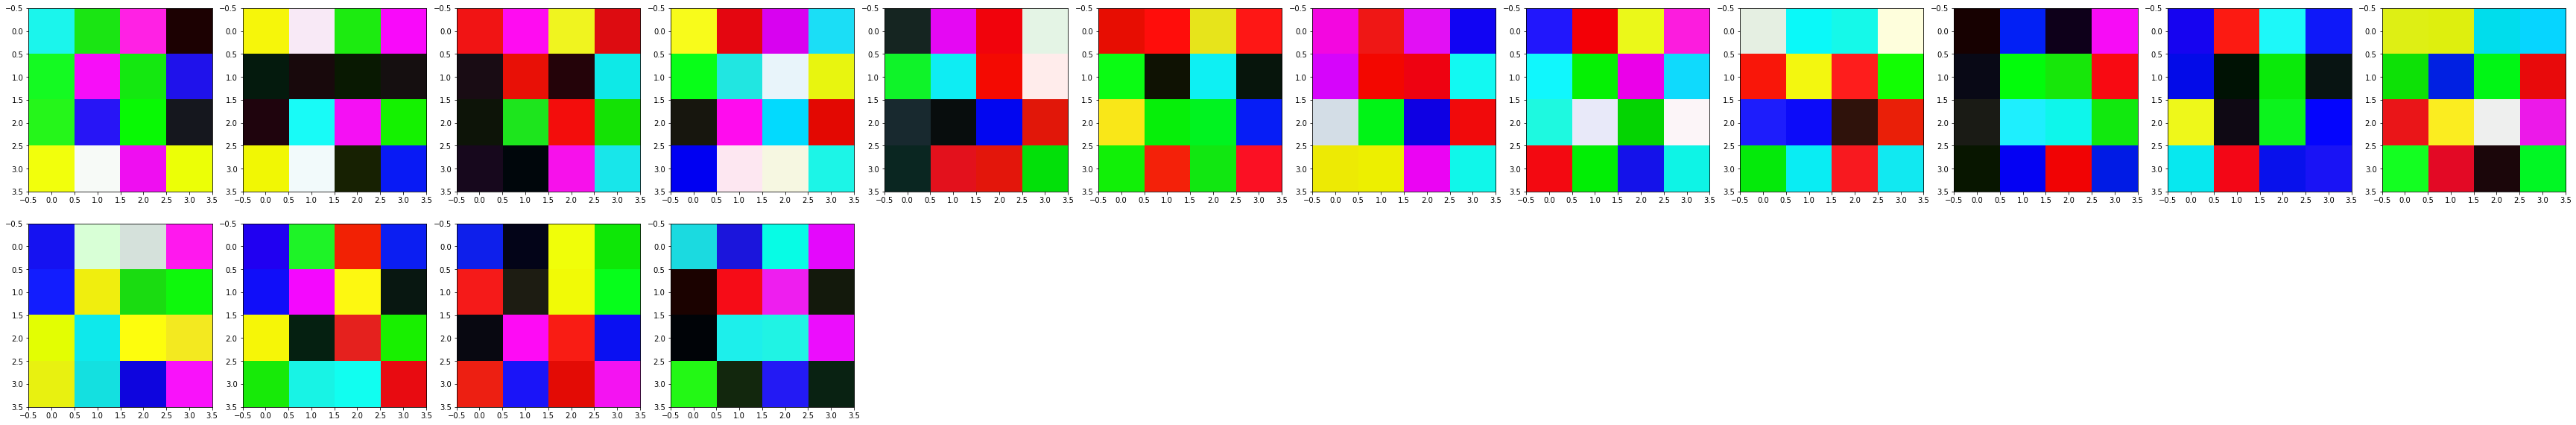

In [27]:
def plot_conv1_kernels(data, step):
    """
    Plots the 96 conv1 kernels in a 12 x 8 subplot grid.
    
    You will need to EDIT this function.
    """
    print('Iteration step: %d' % step)
    kernels = np.array(data['conv_kernel'])[0,::]
    ### YOUR CODE HERE
    xc = 0
    yc = 0
    ncols = 12
    nrows = 8
    plot_size = 4
    f = plt.figure(figsize=(plot_size*ncols, plot_size*nrows))
    for kernelID in range(kernels.shape[3]):
        kernel = kernels[:,:,:,kernelID]
        plt.subplot(nrows, ncols, kernelID+1)
        plt.imshow(kernel)
    plt.tight_layout()
    ### END OF YOUR CODE
           
plot_conv1_kernels(data_6, step)

These kernels are out of this world.